# Personalized Relocation Helper
This project analyzes crime data, housing prices, and points of interest (POI) data for 10 US States of Interest. The crime data includes violent, non-violent, and total crime for each state in 2018-20022. The housing prices data includes the median housing price for each state from 2018-2022. The POI data provides the number of nearby Planetariums, Dog Friendly places, and Vegan Food for cities in each state.

### Code

In [61]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geonamescache
from config import geoapify_key
from config import crime_key

# Read in the Housing Prices CSV
housing_prices_df = pd.read_csv('housing_prices_by_state.csv', encoding='ascii')

### Crime Data
The crime data is collected using the [FBI Crime Data Explorer API]([https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/docApi](https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/docApi)). The API retrieved data on several types of crime *where a charge was made* in each state from 2018-2021 and that was then reported with the Uniform Crime Reporting Program. The types of crime were then sorted to violent and non-violent* crimes and then totaled. This was then pivoted to more clearly display the data. Additionally, the Wikipedia [List of U.S. states and territories by population ](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population)site is used to read into a table to collect the most recent (July 1, 2022 est.) population for each of the States of interest. The population for each state is captured on a DataFrame and then merged with the crime pivot DataFrame. The data is then adjusted per capita (100,000) to provide a more accurate comparison between states regardless of their population size, which eases the bias towards more populous states.

*Note: While violent and non-violent crimes both have significant consequences to individuals and communities, violent crimes are considered more serious due to the physical harm caused, and therefore separate.

In [38]:
# List of states to retrieve crime data for
states = ['CA', 'MI', 'TX', 'CO', 'NC', 'ME', 'MT', 'IA', 'OR', 'IL']

# API base
base_data = 'https://api.usa.gov/crime/fbi/cde/'

# Create empty dataframe to store crime data for all states
crime_df = pd.DataFrame(columns=['State', 'Year', 'Violent Crimes', 'Non-Violent Crimes', 'Total Crimes'])

# Loop through each state to retrieve data
for state in states:
    query = f'arrest/state/{state}/all?from=2018&to=2021&API_KEY='
    response = requests.get(base_data + query + crime_key)
    if response.status_code == 200:
        state_data = json.loads(response.content)['data']
    else:
        print(f"Error: API request for {state} failed with status code {response.status_code}")
        continue
    state_crime_df = pd.DataFrame(state_data)
    # Capture Year for each state
    state_crime_df = state_crime_df.rename(columns={'data_year': 'Year'})
    # Bin types of crime by Violent or Non-Violent
    state_crime_df['Violent Crimes'] = state_crime_df.loc[:, ['Aggravated Assault', 'Murder and Nonnegligent Manslaughter', 'Rape', 'Robbery']].sum(axis=1)
    state_crime_df['Non-Violent Crimes'] = state_crime_df.loc[:, ['All Other Offenses (Except Traffic)', 'Arson', 
                                                'Burglary','Curfew and Loitering Law Violations', 'Disorderly Conduct',
                                                'Driving Under the Influence', 'Drug Abuse Violations - Grand Total',
                                                'Drunkenness', 'Embezzlement', 'Forgery and Counterfeiting', 'Fraud',
                                                'Gambling - Total', 'Human Trafficking - Commercial Sex Acts',
                                                'Human Trafficking - Involuntary Servitude', 'Larceny - Theft',
                                                'Liquor Laws', 'Manslaughter by Negligence', 'Motor Vehicle Theft',
                                                'Offenses Against the Family and Children','Prostitution and Commercialized Vice',
                                                'Stolen Property: Buying, Receiving, Possessing',
                                                'Suspicion', 'Vagrancy', 'Vandalism','Weapons: Carrying, Possessing, Etc.',
                                                'Sex Offenses (Except Rape, and Prostitution and Commercialized Vice)', 'Simple Assault']].sum(axis=1)
    # Drop Types of Crimes
    state_crime_df.drop(labels=['Aggravated Assault','All Other Offenses (Except Traffic)', 'Arson', 'Burglary',
                                                'Curfew and Loitering Law Violations', 'Disorderly Conduct','Driving Under the Influence',
                                                'Drug Abuse Violations - Grand Total', 'Drunkenness', 'Embezzlement', 
                                                'Forgery and Counterfeiting', 'Fraud','Gambling - Total', 
                                                'Human Trafficking - Commercial Sex Acts', 'Human Trafficking - Involuntary Servitude',
                                                'Larceny - Theft', 'Liquor Laws', 'Manslaughter by Negligence', 'Motor Vehicle Theft',
                                                'Murder and Nonnegligent Manslaughter', 'Offenses Against the Family and Children',
                                                'Prostitution and Commercialized Vice','Rape', 'Robbery', 'Simple Assault', 
                                                'Stolen Property: Buying, Receiving, Possessing', 'Suspicion', 'Vagrancy', 'Vandalism','Weapons: Carrying, Possessing, Etc.',
                                                'Sex Offenses (Except Rape, and Prostitution and Commercialized Vice)'],axis=1, inplace=True)
    # Add Violent and Non-Violent Crimes to create Total Crimes Column
    state_crime_df['Total Crimes'] = state_crime_df.loc[:, ['Non-Violent Crimes', 'Violent Crimes']].sum(axis=1)
    # Add State name
    state_crime_df['State'] = state
    # Plug in retrieved data to the all_crime_data_df
    crime_df = pd.concat([crime_df, state_crime_df[["State", "Year", "Violent Crimes", "Non-Violent Crimes", "Total Crimes"]]])
    crime_df

In [39]:
# Pivot 
crime_pivot = crime_df.pivot_table(values=['Violent Crimes', 'Non-Violent Crimes', 'Total Crimes'], index=['State'], columns=['Year'], fill_value=0)

# Format multi-level column for clarity
crime_pivot.columns = ['{}_{}'.format(col[1], col[0]) for col in crime_pivot.columns]

# Reset the index to get the State column back
crime_pivot = crime_pivot.reset_index()

### Housing Data
The housing price data is collected from a csv file on the [Zillow Research Data](https://www.zillow.com/research/data/) website. The data was narrowed to only include 2018-2022 data for the 10 states of interest. Interpolate was used to get the average of adjacent cells in a State row when there was an absent value. The median house price for each year by state was then calculated.

In [5]:
# Drop unnecessary columns
housing_prices_df = housing_prices_df.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])

# Rename 'RegionName' 'State'
housing_prices_df = housing_prices_df.rename(columns={'RegionName': 'State'})

# Keep only States of interest
housing_prices_df = housing_prices_df[housing_prices_df['State'].isin(['California', 'Michigan', 'Texas', 'Colorado', 'North Carolina', 'Maine', 'Montana', 'Iowa', 'Oregon', 'Illinois'])]

# Rename States with abbreviations
state_abbreviations = {'California': 'CA', 'Michigan': 'MI', 'Texas': 'TX', 'Colorado': 'CO', 'North Carolina': 'NC', 'Maine': 'ME', 'Montana': 'MT', 'Iowa': 'IA', 'Oregon': 'OR', 'Illinois': 'IL'}
housing_prices_df['State'] = housing_prices_df['State'].replace(state_abbreviations)

# Select 2018 - 2022 data
columns_to_keep = [col for col in housing_prices_df.columns if col.endswith("/2018") or col.endswith("/2019") or col.endswith("/2020") or col.endswith("/2021") or col.endswith("/2022")]
columns_to_keep = ['State'] + columns_to_keep

housing_df = housing_prices_df[columns_to_keep].copy()

In [6]:
# Set the State column as the index
housing_df = housing_df.set_index('State')

# Interpolate missing values along the rows(states)
housing_df = housing_df.interpolate(axis=1)

housing_df = housing_df.astype(int)

# Reset the index
housing_df = housing_df.reset_index()

In [7]:
# Get the median house price for each year and state
years = ['2018', '2019', '2020', '2021', '2022']
for year in years:
    year_columns = [col for col in housing_df.columns if col.endswith(f"/{year}")]
    year_median = housing_df[year_columns].median(axis=1)
    housing_df[year] = year_median.apply(lambda x: '{:,.0f}'.format(x))

# Arrange columns
housing_df = housing_df[['State', '2018', '2019', '2020', '2021', '2022']]

### Points of Interest 
Using [GeonamesCache](https://pypi.org/project/geonamescache/), a list of cities (pop. >15000) in each of the states of interest generates. Then, [Geoapify](https://apidocs.geoapify.com/) searches for Planetariums, places where dogs are allowed, and places where you can get vegan food within a 5 mile radius of each city. These three variables were selected based on the idea of a demo client wanting to further narrow down their search for a place to relocate. The data is then adjusted per capita (1,000,000)to provide a more accurate comparison between states regardless of their population size, which eases the bias towards more populous states. Additionally, the Wikipedia [List of U.S. states and territories by population ](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population)site is used to read into a table to collect the most recent (July 1, 2022 est.) population for each of the States of interest. The population for each state is captured on a DataFrame and then merged with the DataFrame containing POIs in States of interest. The data is then adjusted per capita (100,000) to provide a more accurate comparison between states regardless of their population size, which eases the bias towards more populous states.

In [10]:
# Initialize GeonamesCache
gc = geonamescache.GeonamesCache()

# Get the states and cities from the GeonamesCache object
states = gc.get_us_states()
cities = gc.get_cities()

# Convert the cities dictionary to a dataframe
cities_in_states_df = pd.DataFrame(list(cities.values()), columns=list(cities.values())[0].keys())

# Filter the dataframe to only include cities in selected states
selected_states = ['CA', 'MI', 'TX', 'CO', 'NC', 'ME', 'MT', 'IA', 'OR', 'IL']
cities_in_states_df = cities_in_states_df[cities_in_states_df['admin1code'].isin(selected_states)]

# Rename columns for clarity
column_names = {'name': 'City', 'latitude': 'Latitude', 'longitude': 'Longitude',
                'population': 'City Population', 'admin1code': 'State'}
cities_in_states_df.rename(columns=column_names, inplace=True)

# Drop unnecessary columns, label index column, reorder columns
drop_columns = ['geonameid', 'timezone', 'alternatenames', 'countrycode']
cities_in_states_df = cities_in_states_df.drop(columns=drop_columns).rename_axis('ID').reset_index()
column_order = ['State', 'City', 'Latitude', 'Longitude', 'City Population']
cities_in_states_df = cities_in_states_df[column_order]

# City Poi
city_poi_df = cities_in_states_df[['Latitude', 'Longitude', 'City', 'State', 'City Population']].copy()

# Set parameters for Planetarium, Dog Friendly, and Vegan Food Places search
radius = 5 * 1609.344  # to convert to miles
categories = {'planetarium': 'entertainment.planetarium', 'dog': 'dogs', 'vegan food': 'vegan'}

# Loop through the cities to search for Planetarium, Dog Friendly, and Vegan Food Places
for category_name, category_value in categories.items():
    # Add a column for the category
    city_poi_df[f'{category_name.capitalize()}'] = ""

    # Set parameters to search for the category
    params = {'categories': category_value, 'apiKey': geoapify_key, 'limit': 300}

    for index, row in city_poi_df.iterrows():
        # Get latitude, longitude
        latitude = row['Latitude']
        longitude = row['Longitude']

        # Add the current city's latitude and longitude to the params dictionary
        params['filter'] = f'circle:{longitude},{latitude},{radius}'
        params['bias'] = f'proximity:{longitude},{latitude}'

        # Set base URL and make an API request using the params dictionary
        base_url = 'https://api.geoapify.com/v2/places'
        name_address = requests.get(base_url, params=params).json()

        # Store the number of POIs in the response in a new column in the DataFrame
        city_poi_df.loc[index, f'Num of {category_name.capitalize()}'] = len(name_address['features'])

        # Grab the first POI and store the name
        try:
            city_poi_df.loc[index, f'{category_name.capitalize()}'] = name_address['features'][0]['properties']['name']
        except (KeyError, IndexError):
            # If no POI is found: "Not {category_name.capitalize()} Friendly"
            city_poi_df.loc[index, f'{category_name.capitalize()}'] = f'Not {category_name.capitalize()} Friendly'


In [12]:
# Rename new dataframe, drop the first names of places found for clarity
cities_poi_df = city_poi_df.drop(['Planetarium', 'Dog', 'Vegan food'], axis=1)

# Rename columns for clarity
column_names = {'Num of Planetarium': 'Num of Planetariums', 'Num of Dog': 'Num of Dog Friendly Places', 'Num of Vegan food': 'Num of Vegan Food Places'}

cities_poi_df = cities_poi_df.rename(columns=column_names)

In [13]:
# Group by state
build_state_poi_df = cities_poi_df.groupby('State', as_index=False).agg({
    'Latitude': 'first',
    'Longitude': 'first',
    'City Population': 'sum',
    'Num of Planetariums': 'sum',
    'Num of Dog Friendly Places': 'sum',
    'Num of Vegan Food Places': 'sum',
})

In [14]:
# Read html for wiki page with accurate populations
pop_df = pd.read_html("https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population")[0]

# Drop level for clarity
pop_df.columns = pop_df.columns.droplevel(0)

# List States of Interest
list_states = ['California', 'Michigan', 'Texas', 'Colorado', 'North Carolina', 'Maine', 'Montana', 'Iowa', 'Oregon', 'Illinois']

# Filter for population
state_populations = pop_df[pop_df['State or territory'].isin(list_states)][['State or territory', "July 1, 2022 (est.)"]]

# Rename the columns 
state_populations.columns = ['State', 'State Population']

# Replace state names with abbreviations
state_populations['State'] = state_populations['State'].replace(['California', 'Michigan', 'Texas', 'Colorado', 'North Carolina', 
'Maine', 'Montana', 'Iowa', 'Oregon', 'Illinois'], ['CA', 'MI', 'TX', 'CO', 'NC', 'ME', 'MT', 'IA', 'OR', 'IL'])

In [15]:
# Merge dataframes to build State POI DF
state_poi_df = build_state_poi_df.merge(state_populations, on='State')
state_poi_df.drop('City Population', axis=1, inplace=True)

In [51]:
# Copy state_poi_df to create per_capita_state_poi to hold the POI per capita 
per_capita_state_poi = state_poi_df.copy()

# Calculate per capita 
per_capita_state_poi[['Num of Planetariums per capita', 'Num of Dog Friendly Places per capita', 'Num of Vegan Food Places per capita']] = per_capita_state_poi[['Num of Planetariums', 'Num of Dog Friendly Places', 'Num of Vegan Food Places']].div(per_capita_state_poi['State Population'], axis=0) * 1000000

# Drop the unnecessary columns
per_capita_state_poi.drop(['Num of Planetariums', 'Num of Dog Friendly Places', 'Num of Vegan Food Places'], axis=1, inplace=True)

,State,Latitude,Longitude,State Population,Num of Planetariums per capita,Num of Dog Friendly Places per capita,Num of Vegan Food Places per capita
0,CA,34.39916,-118.91815,39029342.0,1.819144,59.801162,40.354254
1,CO,-9.31286,125.25648,5839926.0,0.684940,98.973857,28.082548
2,IA,41.64416,-93.46466,3200517.0,0.937349,1.562248,0.312450
3,IL,38.89060,-90.18428,12582032.0,3.338094,33.937285,80.670594
4,ME,44.09785,-70.23117,1385340.0,0.000000,102.501913,12.993200
5,MI,42.29420,-83.30993,10034113.0,0.996600,8.371442,13.454104
6,MT,45.78329,-108.50069,1122867.0,0.000000,14.249239,1.781155
7,NC,35.35014,-80.20006,10698973.0,0.280401,24.207931,8.505489
8,OR,44.63651,-123.10593,4240137.0,0.943366,75.705101,87.497173
9,TX,32.44874,-99.73314,30029572.0,0.366306,27.739323,7.093008


### Adjusting Crime Per Capita

In [43]:
# New dataframe to hold Crime per capita
build_per_capita_crime = crime_pivot.merge(state_populations, on='State')

In [42]:
# Copy build_per_capita 
per_capita_crime = build_per_capita_crime.copy()

# Divide each column by the 'State Population' column
per_capita_crime.iloc[:, 1:-1] = per_capita_crime.iloc[:, 1:-1].div(per_capita_crime['State Population'], axis=0) * 100000

## Visualizations

### Crime Visualizations
1. How does violent, non-violent, and total crime compare across 2018-2021 for our States of Interest?
   The total number of crimes has decreased from 2018 to 2021 in most states. Some states have vastly different crimes rates (that were reported and recorded, see caveat!). Here are two visualizations to show that:

   *The subplot of horizontal stacked bar graphs visualizes the comparison of violent, non-violent, and total crimes per state in each year (2018, 2019, 2020, 2021)

   *The visualization_type shows...

# Alejandra 
I updated the horizontal stacked bar graph for 2018 to make sure we were on the right path with per capita and look how pretty it is! 
In looking over the requirements, 2 visualizations are needed per questions. So we need to throw in another graph for crime (I threw in a weird scatter plot for housing). One that shows total crime over year by state could be good- you could use the multiple line graph code i did for housing to mock something up? Or your tutor might have a good suggestion. Because we have outliers (like IL and CA's 2021) I thought a boxplot might be worth a look... but didn't get far. But I kept what I did do. It's right below:

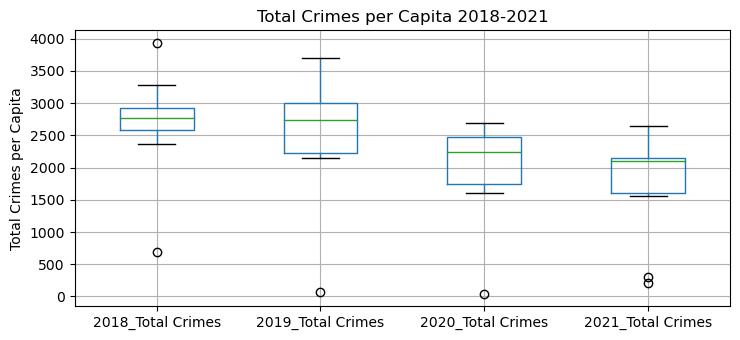

In [88]:
# Box Plot to show outliers
columns = ['2018_Total Crimes', '2019_Total Crimes', '2020_Total Crimes', '2021_Total Crimes']
per_capita_crime.boxplot(column=columns)

plt.title('Total Crimes per Capita 2018-2021')
plt.ylabel('Total Crimes per Capita')

plt.show()

In [48]:
per_capita_crime

,State,2018_Non-Violent Crimes,2019_Non-Violent Crimes,2020_Non-Violent Crimes,2021_Non-Violent Crimes,2018_Total Crimes,2019_Total Crimes,2020_Total Crimes,2021_Total Crimes,2018_Violent Crimes,2019_Violent Crimes,2020_Violent Crimes,2021_Violent Crimes,State Population
0,CA,2518.840825,2408.249670,1914.679986,194.182110,2801.284736,2676.896269,2172.380974,205.255830,282.443911,268.646599,257.700988,11.073720,39029342.0
1,CO,3786.212360,3544.736697,2491.195950,2494.586404,3935.666308,3694.498869,2646.334902,2638.235484,149.453949,149.762172,155.138952,143.649080,5839926.0
2,IA,2606.953814,2897.063193,2348.245612,1983.179593,2734.027034,3058.380880,2513.656387,2135.030059,127.073220,161.317687,165.410776,151.850467,3200517.0
3,IL,644.323588,60.618189,41.400308,288.315910,688.330788,64.417258,44.635080,302.304111,44.007200,3.799068,3.234772,13.988202,12582032.0
4,ME,2898.133310,2769.139706,2273.016011,2048.305831,2952.776936,2819.019158,2323.833860,2097.824361,54.643625,49.879452,50.817850,49.518530,1385340.0
5,MI,2239.948862,2018.693630,1478.137629,1425.397541,2367.972137,2145.331630,1607.855124,1551.816289,128.023274,126.638000,129.717495,126.418748,10034113.0
6,MT,2478.655086,2629.162670,2503.324080,2239.535047,2599.061153,2793.296089,2694.531053,2396.276674,120.406068,164.133419,191.206973,156.741627,1122867.0
7,NC,2702.474340,2115.773168,1764.963796,2009.847113,2836.449816,2208.015667,1859.954222,2105.052513,133.975476,92.242498,94.990426,95.205400,10698973.0
8,OR,3165.440173,3178.057690,2261.695790,2026.396789,3278.832736,3300.482980,2375.843045,2149.836196,113.392563,122.425290,114.147255,123.439408,4240137.0
9,TX,2465.742768,2135.684784,1609.613350,1645.424717,2584.725483,2254.394435,1715.349123,1748.549730,118.982715,118.709651,105.735773,103.125013,30029572.0


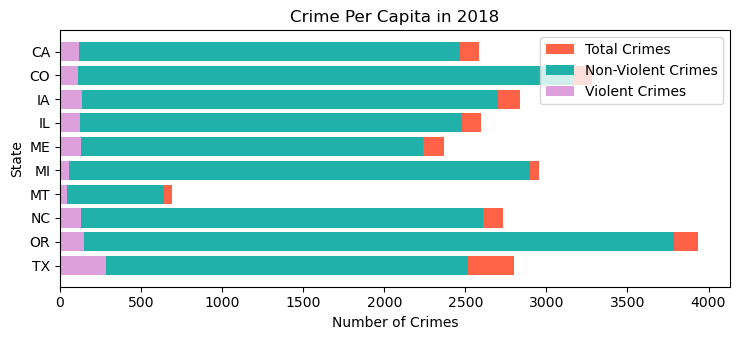

<Figure size 750x350 with 0 Axes>

In [100]:
# Horizontal Stacked Bar Graph for Crime 2018
### needs to be on subplot
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

Total_Crime = [2801.284736, 3935.666308, 2734.027034, 688.330788, 2952.776936, 2367.972137, 2599.061153, 2836.449816, 3278.832736, 2584.725483]
Non_Violent_Crime = [2518.840825, 3786.212360, 2606.953814, 644.323588, 2898.133310, 2239.948862, 2478.655086, 2702.474340, 3165.440173, 2465.742768]
Violent_Crime = [282.443911, 149.453949, 127.073220, 44.007200, 54.643625, 128.023274, 120.406068, 133.975476, 113.392563, 118.982715]
labels = ['TX','OR','NC','MT','MI','ME','IL','IA','CO','CA']

b1 = plt.barh(labels, Total_Crime, color="tomato")
b2 = plt.barh(labels, Non_Violent_Crime, color="lightseagreen")
b3 = plt.barh(labels, Violent_Crime, color="plum")

plt.title("Crime Per Capita in 2018")
plt.xlabel("Number of Crimes")
plt.ylabel("State")
plt.legend([b1,b2,b3], ["Total Crimes", "Non-Violent Crimes", "Violent Crimes"], loc="upper right")

plt.show()
# Save plot as PNG
plt.savefig('crimes_per_capita_horizontal_stacked_bar.png')

### Housing Visualization
2. How do median housing prices compare for our States of Interest from 2018-2022?

   We have two visualizations below to show that housing prices have gone up over time across the states, with a slow down in 2020 before seeing a steeper incline.

      *The multiple line graph visualizes the prices of homes over time with lines representing each state.

      *The scatter plot visualizes the prices of homes by state with the data points representing each year (2018-2022).

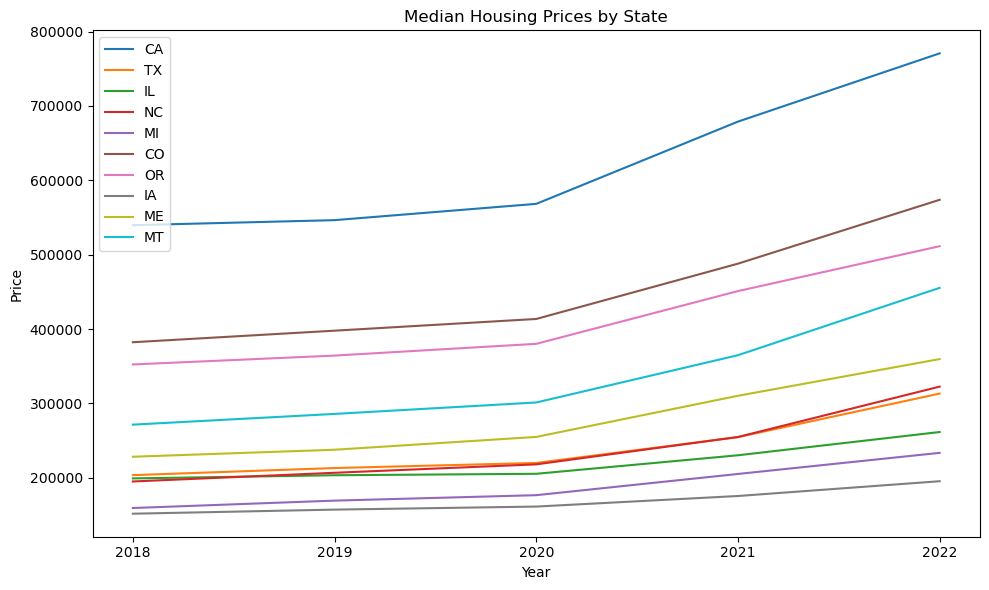

<Figure size 750x350 with 0 Axes>

In [80]:
# Multiple line graph of median housing prices in States of interest 2018-2022
# Each state's median housing price between 2018-2022
housing_prices = [[539576, 546365, 568272, 678849, 770635],
                  [203496, 213051, 219912, 254620, 313171],
                  [199116, 203379, 205314, 230218, 261490],
                  [194988, 206680, 218010, 254784, 322528],
                  [159290, 169243, 176564, 205098, 233470],
                  [382204, 397746, 413495, 487849, 573716],
                  [352330, 364256, 380062, 450984, 511343],
                  [151652, 157152, 161242, 175456, 195330],
                  [228248, 237650, 254896, 310226, 359572],
                  [271398, 285826, 301200, 364764, 455346]]

states = ['CA', 'TX', 'IL', 'NC', 'MI', 'CO', 'OR', 'IA', 'ME', 'MT']

years = [2018, 2019, 2020, 2021, 2022]

# Adjust figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Create multiple line graph using a loop
for i, state in enumerate(states):
    plt.plot(years, housing_prices[i], label=state)

# Labels
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Median Housing Prices by State')
plt.legend()
plt.xticks(years, [int(year) for year in years])

plt.show()

# Save plot as PNG
plt.savefig('median_housing_prices_line.png')

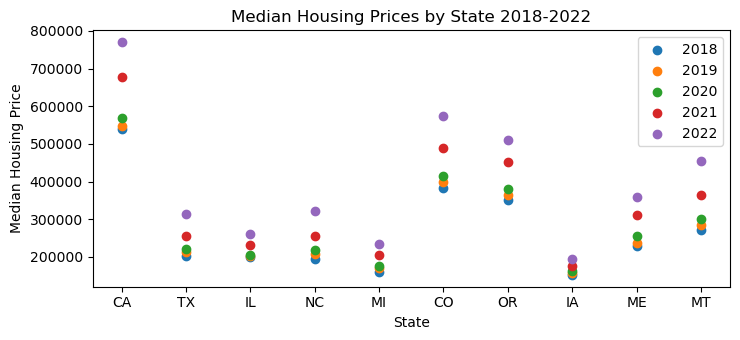

<Figure size 750x350 with 0 Axes>

In [119]:
# Scatter Plot of median housing prices in States of interest 2018-2022
# Each state's median housing price between 2018-2022
housing_prices2 = {'State': ['CA', 'TX', 'IL', 'NC', 'MI', 'CO', 'OR', 'IA', 'ME', 'MT'],
        '2018': [539576, 203496, 199116, 194988, 159290, 382204, 352330, 151652, 228248, 271398],
        '2019': [546365, 213051, 203379, 206680, 169243, 397746, 364256, 157152, 237650, 285826],
        '2020': [568272, 219912, 205314, 218010, 176564, 413495, 380062, 161242, 254896, 301200],
        '2021': [678849, 254620, 230218, 254784, 205098, 487849, 450984, 175456, 310226, 364764],
        '2022': [770635, 313171, 261490, 322528, 233470, 573716, 511343, 195330, 359572, 455346]}

housing_prices2_df = pd.DataFrame(housing_prices2)

# Scatter Plot
plt.scatter(housing_prices2_df['State'], housing_prices2_df['2018'], label='2018')
plt.scatter(housing_prices2_df['State'], housing_prices2_df['2019'], label='2019')
plt.scatter(housing_prices2_df['State'], housing_prices2_df['2020'], label='2020')
plt.scatter(housing_prices2_df['State'], housing_prices2_df['2021'], label='2021')
plt.scatter(housing_prices2_df['State'], housing_prices2_df['2022'], label='2022')

# Labels
plt.xlabel('State')
plt.ylabel('Median Housing Price')
plt.legend()
plt.title('Median Housing Prices by State 2018-2022')

# Show the plot
plt.show()

# Save plot as PNG
plt.savefig('median_housing_prices_scatter.png')# Save plot as PNG

### Points of Interest Visualizations
3. Where can I find the points of interest in our states of interest on a map by city and state?
   We have two maps below to show where the points of interest are. It's interactive in the notebook so you can also hover over a radius (in relation to the city or state population) and see the number of POIs in the area as well as the city or state population.How do median housing prices compare for our States of Interest from 2018-2022?

      *The Points of Interst by City in States of Interest map displays POIs in cities in states of interest.

      *The Points of Interest in States of Interest map displays POIs in states of interest.
4. What states have the most Planetariums, Dog Friendly Places, and Vegan Food Places per capita? 
      Illinois has the most Planetariums per capita, Maine has the most Dog Friendly Places per capita at 102.50 though Colorado is close behind with 98.97, and Oregon has the most Vegan Food Places at 87.49 though Illinois isn't too far behind with 80.67.
      
      *The subplot of piecharts visualizes how states compare based on each POI.
      
      *The grouped barchart is another way to visualize how states compare based on each POI.

In [75]:
%%capture --no-display

# Map of Points of Interest by City in States of Interest 
cities_poi_map = cities_poi_df.hvplot.points(
    x='Longitude',
    y='Latitude',
    geo=True,
    size=cities_poi_df['City Population'] * 0.001, #Size of plots are in relation to population size of city
    hover_cols=['City', 'State', 'Num of Planetariums', 'Num of Dogs Friendly Places','Num of Vegan Food Places', 'City Population'],
    color='State',
    tiles=True,
    alpha=0.4,
    width=900,
    height=500, 
    title='Points of Interest by City in States of Interest'
)
# Display map
cities_poi_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (State,_size,City,Num of Planetariums,Num of Vegan Food Places,City Population)

In [72]:
%%capture --no-display

# Map of Points of Interest in States of Interest 
state_poi_map = state_poi_df.hvplot.points(
    x='Longitude',
    y='Latitude',
    geo=True,
    size=state_poi_df['State Population'] * 0.0005, #Size of plots are in relation to population size of city
    hover_cols=['State', 'Longitude', 'Latitude', 'Num of Planetariums', 'Num of Dogs Friendly Places','Num of Vegan Food Places', 'State Population'],
    color='State',
    tiles=True,
    alpha=0.4,
    width=900,
    height=500, 
    title='Points of Interest in States of Interest'
)

state_poi_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (State,_size,Num of Planetariums,Num of Vegan Food Places,State Population)

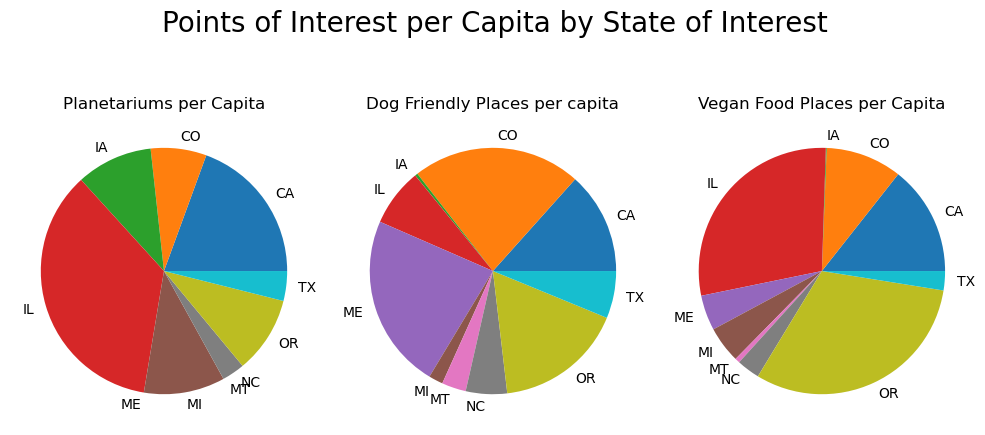

<Figure size 750x350 with 0 Axes>

In [116]:
# Subplot of piecharts for POI
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# 1 Num of Vegan Food Places per Capita
ax[0].pie(per_capita_state_poi['Num of Planetariums per capita'], labels=per_capita_state_poi['State'])
ax[0].set_title('Planetariums')

# 2 Num of Dog Friendly Places per capita
ax[1].pie(per_capita_state_poi['Num of Dog Friendly Places per capita'], labels=per_capita_state_poi['State'])
ax[1].set_title('Dog Friendly Places')

# 3 Num of Vegan Food Places per Capita
ax[2].pie(per_capita_state_poi['Num of Vegan Food Places per capita'], labels=per_capita_state_poi['State'])
ax[2].set_title('Vegan Food Places')

# Title the subplot
plt.suptitle("Points of Interest per Capita by State of Interest", fontsize=20)

plt.show()

# Save plot as PNG
plt.savefig('pie_chart_poi.png')# Save plot as PNG

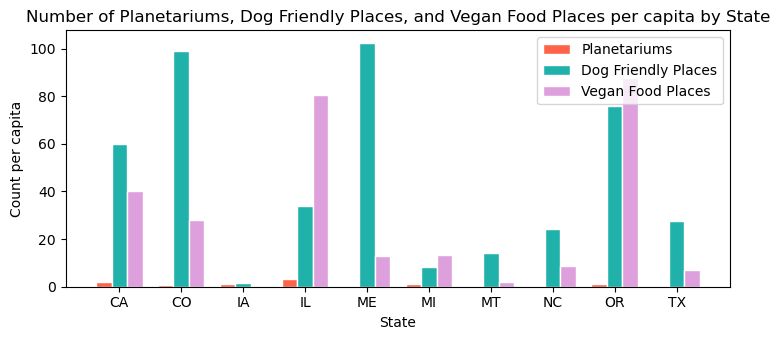

<Figure size 750x350 with 0 Axes>

In [118]:
# Grouped bar chart for POI
# Get information from per_capita_state_poi DF
labels = per_capita_state_poi['State']
planetariums = per_capita_state_poi['Num of Planetariums per capita']
dog_friendly_places = per_capita_state_poi['Num of Dog Friendly Places per capita']
vegan_food_places = per_capita_state_poi['Num of Vegan Food Places per capita']

bar_width = 0.25

# Set the x-axis 
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Barchart
plt.bar(r1, planetariums, color='tomato', width=bar_width, edgecolor='white', label='Planetariums')
plt.bar(r2, dog_friendly_places, color='lightseagreen', width=bar_width, edgecolor='white', label='Dog Friendly Places')
plt.bar(r3, vegan_food_places, color='plum', width=bar_width, edgecolor='white', label='Vegan Food Places')

# Labels
plt.xlabel('State')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.ylabel('Count per capita')
plt.title('Number of Planetariums, Dog Friendly Places, and Vegan Food Places per capita by State')
plt.legend()

plt.show()

# Save plot as PNG
plt.savefig('grouped_bar_poi.png')# Save plot as PNG